# ERA5 for Bylot 2019-2025

https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels

#### ERA5 hourly data on single levels from 1940 to present


- **Radiation and heat** / Surface solar thermal downwards: `f88e980e24b1ba4fe8b42cb557ff66ae.nc`
- **Radiation and heat** / Surface solar radiation downwards: `8ef1b5ef403bac84d5778e9bf4b7e26f.nc`
- **Mean rates** / Mean surface downward long-wave radiation flux (test 2019): `23122b75afc3c080d1f85c7b5539b12f.nc`

Note: Mean rates = Radiation and heat/3600



------- 73.35 ------  
-80.05 ------- -79.8    
------- 73.1 ------  

(get 4 closest grid cells)

Downloaded by Mickaël Lalande 27/03/2025
  

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

In [2]:
# Bylot TUNDRA station (Domine et al., 2021: https://essd.copernicus.org/articles/13/4331/2021/)
lat = 73.1504
lon = -80.0046

In [3]:
path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5'

## Surface long-wave (thermal) radiation downwards

In [24]:
ds = xr.open_mfdataset(path+'/LW_down/*.nc')
ds.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 107111, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 4.96e+05 ... 6....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [178]:
# ds = xr.open_dataset(path+'/f88e980e24b1ba4fe8b42cb557ff66ae.nc')
# ds

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 54527, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 436kB 2019-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 872kB ...
Data variables:
    strd        (valid_time, latitude, longitude) float32 872kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-26T23:55 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [15]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 2)> Size: 16B
array([73.35, 73.1 ])
Coordinates:
    number    int64 8B 0
  * latitude  (latitude) float64 16B 73.35 73.1
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [16]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds.latitude.values, lat))
new_lons = np.sort(np.append(ds.longitude.values, lon))

In [17]:
new_lats

array([73.1   , 73.1504, 73.35  ])

In [18]:
new_lons

array([-80.05  , -80.0046, -79.8   ])

In [25]:
ds_interp = ds.interp(latitude=new_lats, longitude=new_lons)
ds_interp

<xarray.Dataset> Size: 10MB
Dimensions:     (valid_time: 107111, latitude: 3, longitude: 3)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
  * latitude    (latitude) float64 24B 73.1 73.15 73.35
  * longitude   (longitude) float64 24B -80.05 -80.0 -79.8
Data variables:
    strd        (valid_time, latitude, longitude) float64 8MB 5.207e+05 ... 5...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
import warnings
warnings.filterwarnings('ignore')

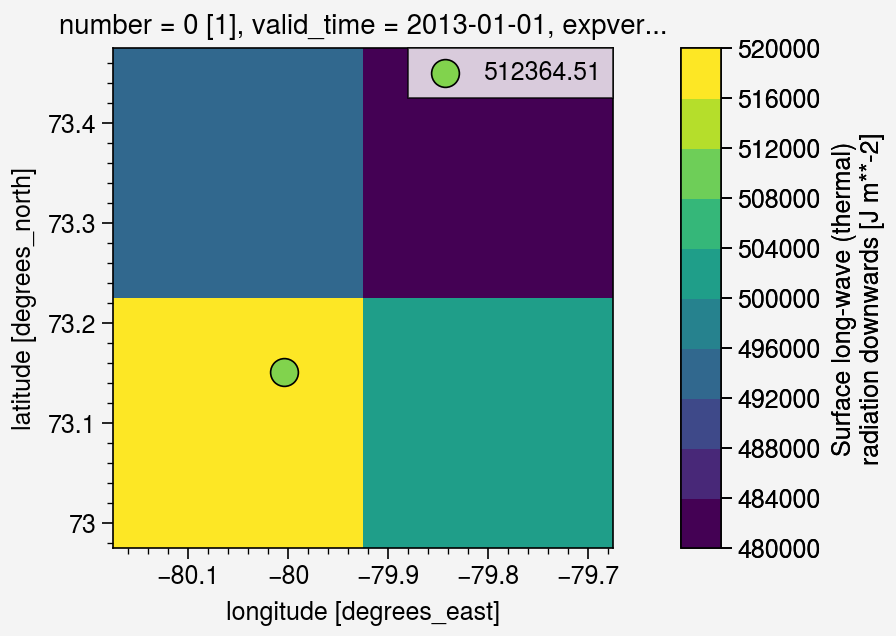

In [26]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 0
pcolor = ds.strd[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.strd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

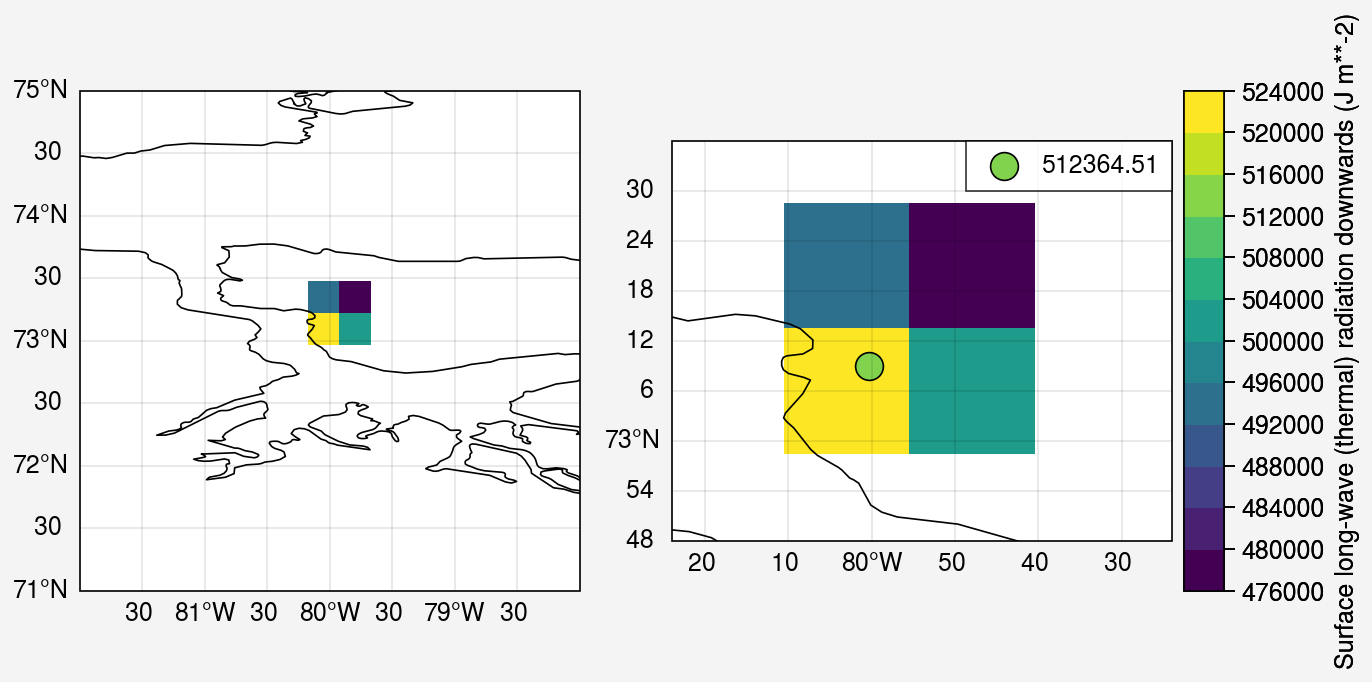

In [27]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 0
ax = axs[0]
ax.pcolormesh(ds.strd[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds.strd[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.strd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


In [28]:
ds_interp.latitude.values

array([73.1   , 73.1504, 73.35  ])

In [29]:
ds_interp.longitude.values

array([-80.05  , -80.0046, -79.8   ])

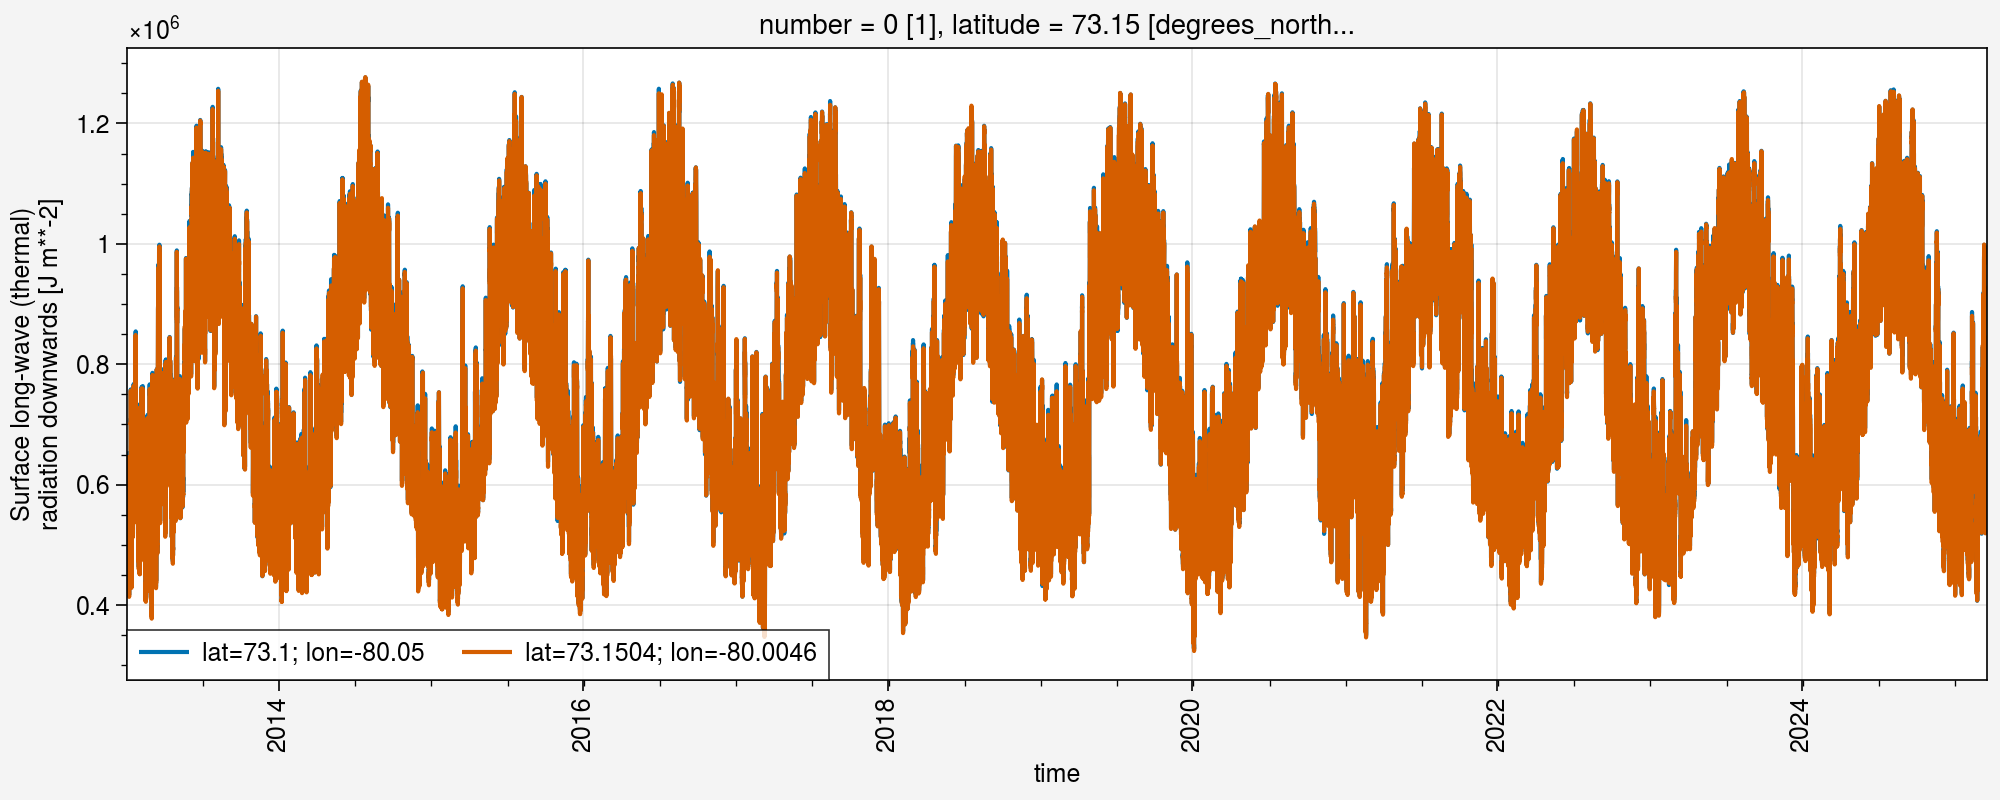

In [32]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.strd.sel(latitude=73.1, longitude=-80.05).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.strd.sel(latitude=73.1504, longitude=-80.0046).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

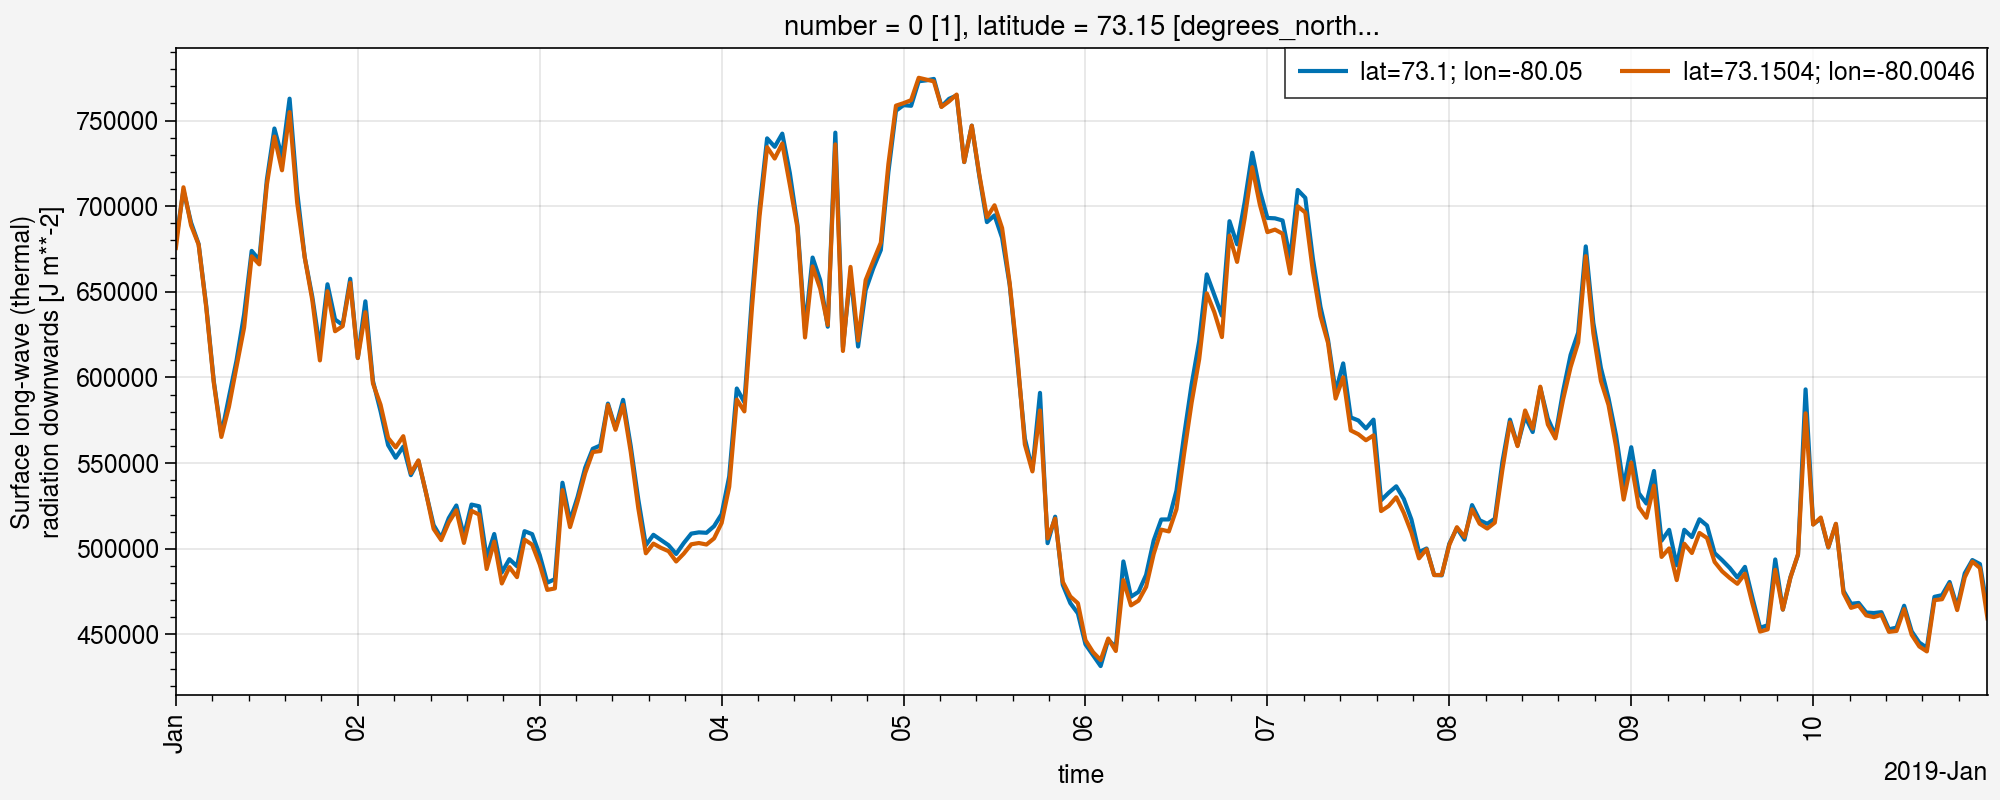

In [33]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.strd.sel(latitude=73.1, longitude=-80.05, valid_time=slice('2019-01-01', '2019-01-10')).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.strd.sel(latitude=73.1504, longitude=-80.0046, valid_time=slice('2019-01-01', '2019-01-10')).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

Need to divide by 3600 to get W m-2 s-1

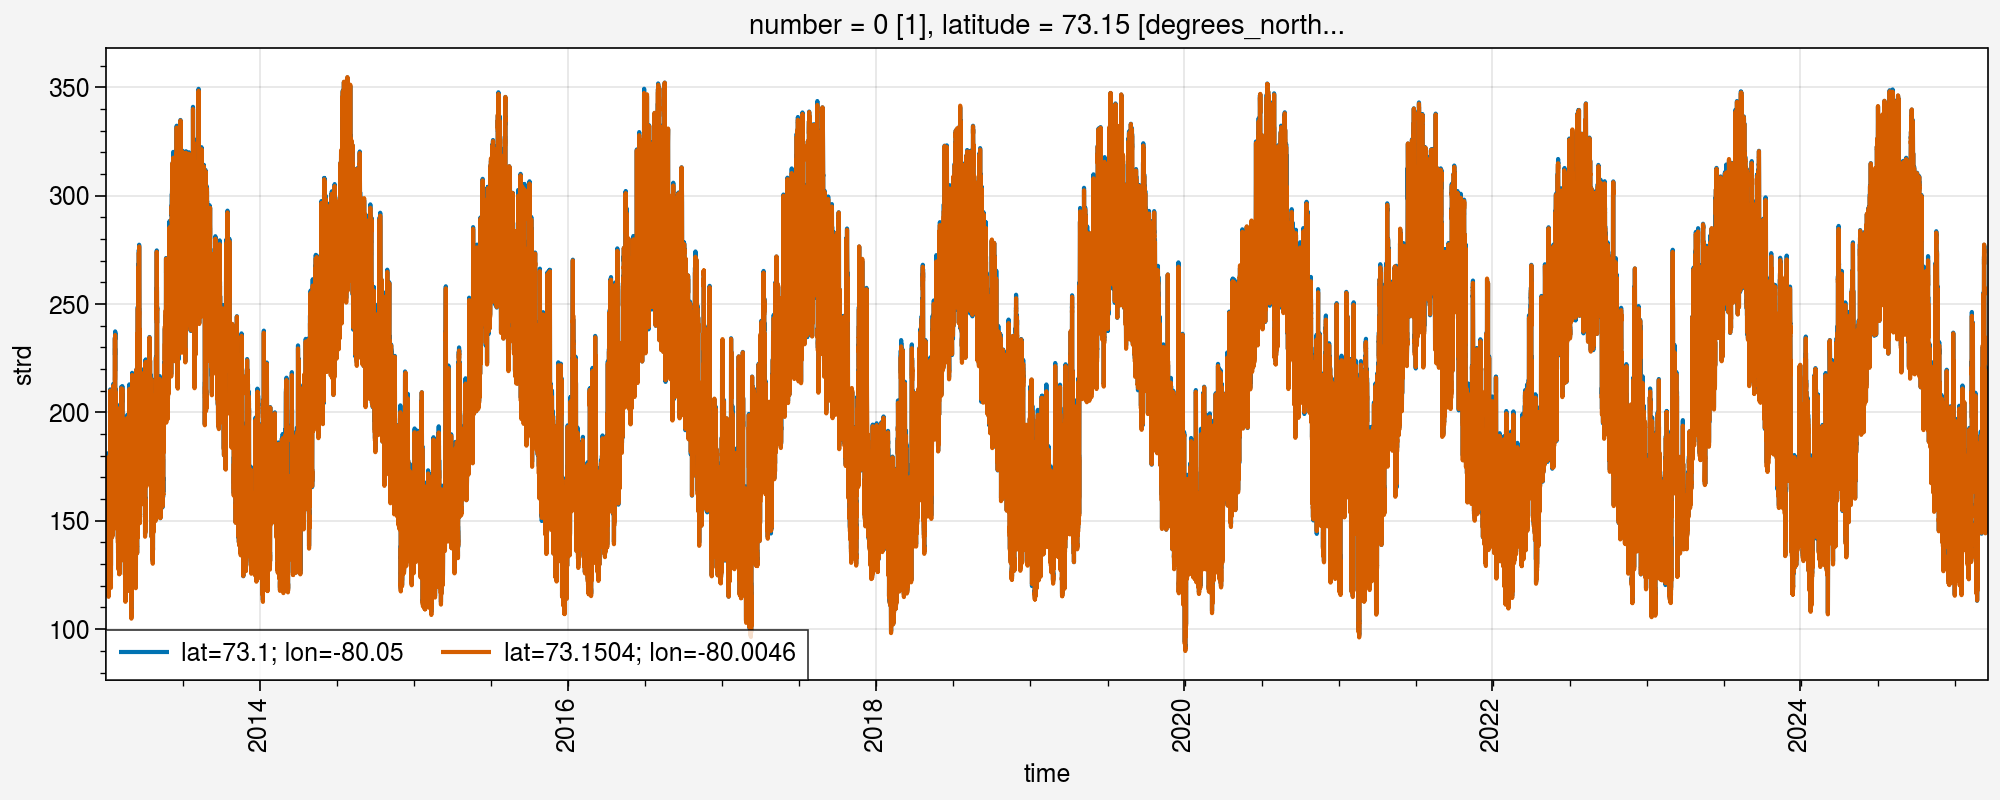

In [34]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

(ds_interp.strd.sel(latitude=73.1, longitude=-80.05)/3600).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
(ds_interp.strd.sel(latitude=73.1504, longitude=-80.0046)/3600).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

## Check with mean rates

In [146]:
ds2 = xr.open_dataset(path+'/23122b75afc3c080d1f85c7b5539b12f.nc')
ds2

<xarray.Dataset> Size: 350kB
Dimensions:     (valid_time: 8760, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 70kB 2019-01-01 ... 2019-12-31T23...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 140kB ...
Data variables:
    avg_sdlwrf  (valid_time, latitude, longitude) float32 140kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T15:33 GRIB to CDM+CF via cfgrib-0.9.1...

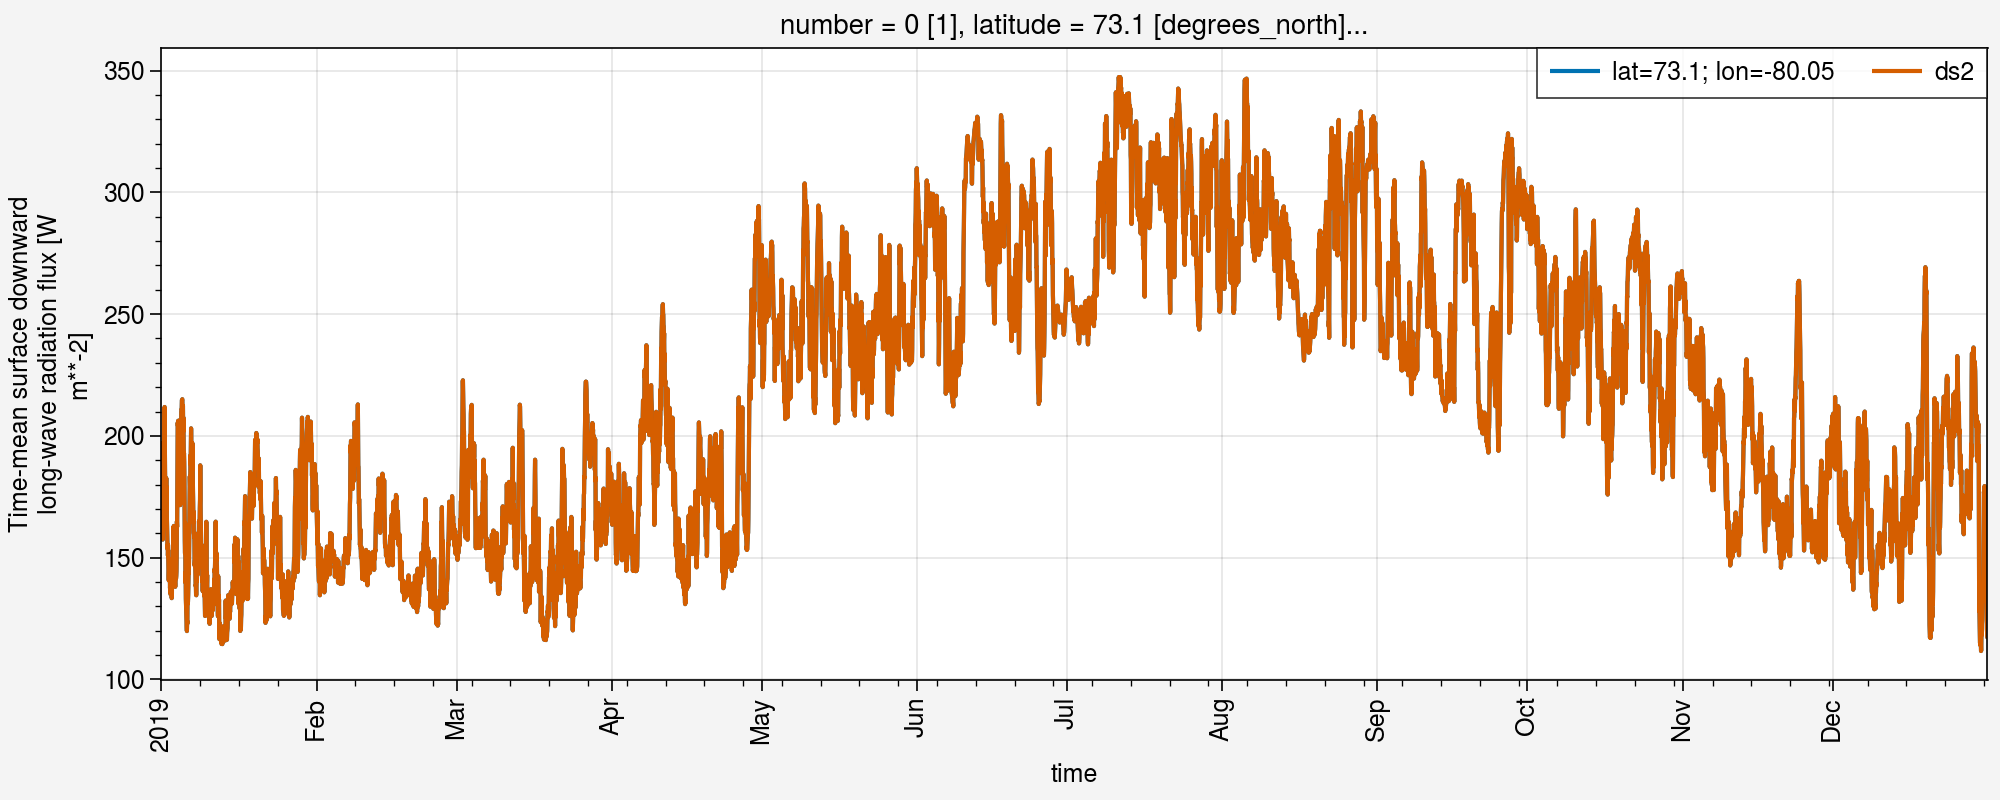

In [154]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

(ds_interp.strd.sel(latitude=73.1, longitude=-80.05, valid_time='2019')/3600).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds2.avg_sdlwrf.sel(latitude=73.1, longitude=-80.05, valid_time='2019').plot(ax=axs[0], label='ds2')
axs.legend()

## Export data to .dat or .csv 
Only pixel including Bylot and interpolated values

In [35]:
ds_interp_out = ds_interp.strd.drop('number').drop('expver').rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds_interp_out = ds_interp_out/3600
ds_interp_out.attrs = {'long_name': 'Surface long-wave (thermal) radiation downwards', 'name': 'strd', 'units': 'W m$^{-2}$ s$^{-1}$'}

ds_interp_out_grid = ds_interp_out.sel(lat=73.1, lon=-80.05)
ds_interp_out_interp = ds_interp_out.sel(lat=73.1504, lon=-80.0046)
ds_interp_out_interp

<xarray.DataArray 'strd' (time: 107111)> Size: 857kB
array([142.32347477, 139.70922053, 145.73005542, ..., 167.99312636,
       171.65158063, 168.13511467])
Coordinates:
  * time     (time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T22:00:00
    lat      float64 8B 73.15
    lon      float64 8B -80.0
Attributes:
    long_name:  Surface long-wave (thermal) radiation downwards
    name:       strd
    units:      W m$^{-2}$ s$^{-1}$

In [36]:
df_grid = ds_interp_out_grid.to_dataframe()
df_grid

lat    lon        strd
time                                        
2013-01-01 00:00:00  73.1 -80.05  144.648698
2013-01-01 01:00:00  73.1 -80.05  141.447778
2013-01-01 02:00:00  73.1 -80.05  147.500556
2013-01-01 03:00:00  73.1 -80.05  138.821840
2013-01-01 04:00:00  73.1 -80.05  144.000347
...                   ...    ...         ...
2025-03-21 18:00:00  73.1 -80.05  186.736823
2025-03-21 19:00:00  73.1 -80.05  170.529288
2025-03-21 20:00:00  73.1 -80.05  168.189444
2025-03-21 21:00:00  73.1 -80.05  171.649983
2025-03-21 22:00:00  73.1 -80.05  168.550486

[107111 rows x 3 columns]

In [37]:
df_grid.to_csv(path+'/ERA5_h_strd_73.1N_80.05W_2013-2025_Bylot_UTC.csv')

In [39]:
df_interp = ds_interp_out_interp.to_dataframe()
df_interp

lat      lon        strd
time                                             
2013-01-01 00:00:00  73.1504 -80.0046  142.323475
2013-01-01 01:00:00  73.1504 -80.0046  139.709221
2013-01-01 02:00:00  73.1504 -80.0046  145.730055
2013-01-01 03:00:00  73.1504 -80.0046  137.481558
2013-01-01 04:00:00  73.1504 -80.0046  142.507157
...                      ...      ...         ...
2025-03-21 18:00:00  73.1504 -80.0046  187.003877
2025-03-21 19:00:00  73.1504 -80.0046  170.216323
2025-03-21 20:00:00  73.1504 -80.0046  167.993126
2025-03-21 21:00:00  73.1504 -80.0046  171.651581
2025-03-21 22:00:00  73.1504 -80.0046  168.135115

[107111 rows x 3 columns]

In [40]:
df_interp.to_csv(path+'/ERA5_h_strd_73.1504N_80.0046W_2013-2025_Bylot_interp_UTC.csv')

## Surface short-wave (solar) radiation downwards

In [42]:
ds = xr.open_mfdataset(path+'/SW_down/*.nc')
ds.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 107110, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 ... 6.123e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [254]:
# ds = xr.open_dataset(path+'/8ef1b5ef403bac84d5778e9bf4b7e26f.nc')
# ds

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 54526, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 436kB 2019-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 872kB ...
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 872kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-26T22:43 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [43]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 2)> Size: 16B
array([73.35, 73.1 ])
Coordinates:
    number    int64 8B 0
  * latitude  (latitude) float64 16B 73.35 73.1
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [44]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds.latitude.values, lat))
new_lons = np.sort(np.append(ds.longitude.values, lon))

In [45]:
new_lats

array([73.1   , 73.1504, 73.35  ])

In [46]:
new_lons

array([-80.05  , -80.0046, -79.8   ])

In [47]:
ds_interp = ds.interp(latitude=new_lats, longitude=new_lons)
ds_interp

<xarray.Dataset> Size: 10MB
Dimensions:     (valid_time: 107110, latitude: 3, longitude: 3)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
  * latitude    (latitude) float64 24B 73.1 73.15 73.35
  * longitude   (longitude) float64 24B -80.05 -80.0 -79.8
Data variables:
    ssrd        (valid_time, latitude, longitude) float64 8MB 0.0 ... 6.106e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [48]:
import warnings
warnings.filterwarnings('ignore')

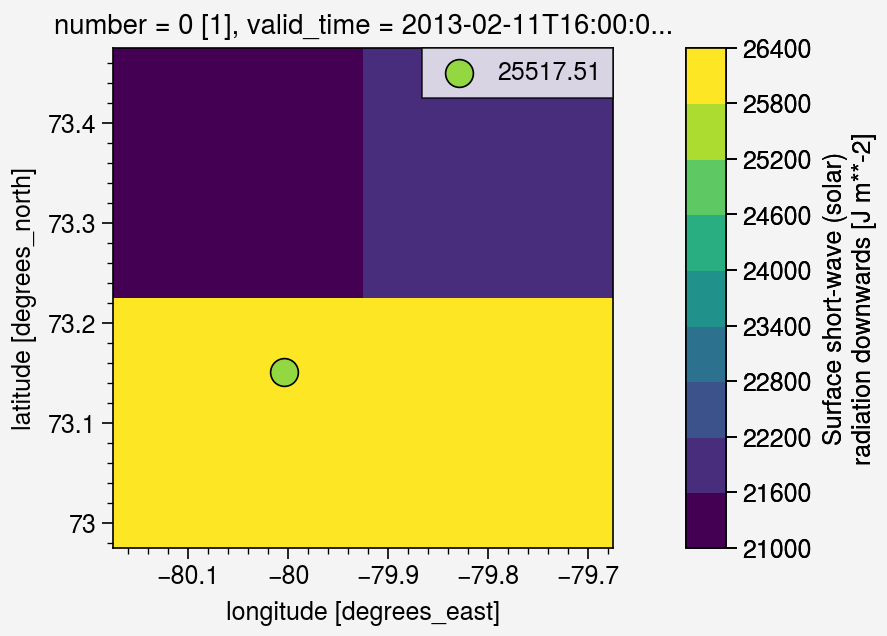

In [49]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 1000
pcolor = ds.ssrd[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.ssrd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

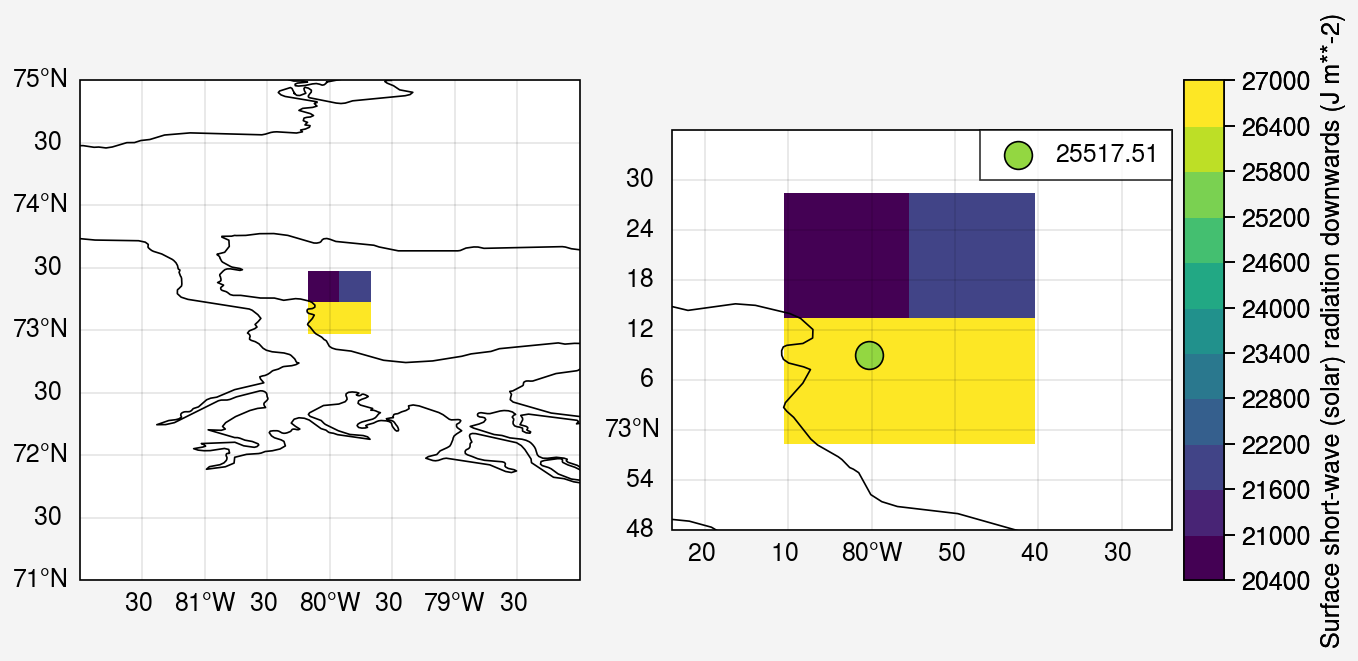

In [50]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 1000
ax = axs[0]
ax.pcolormesh(ds.ssrd[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds.ssrd[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.ssrd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


In [51]:
ds_interp.latitude.values

array([73.1   , 73.1504, 73.35  ])

In [52]:
ds_interp.longitude.values

array([-80.05  , -80.0046, -79.8   ])

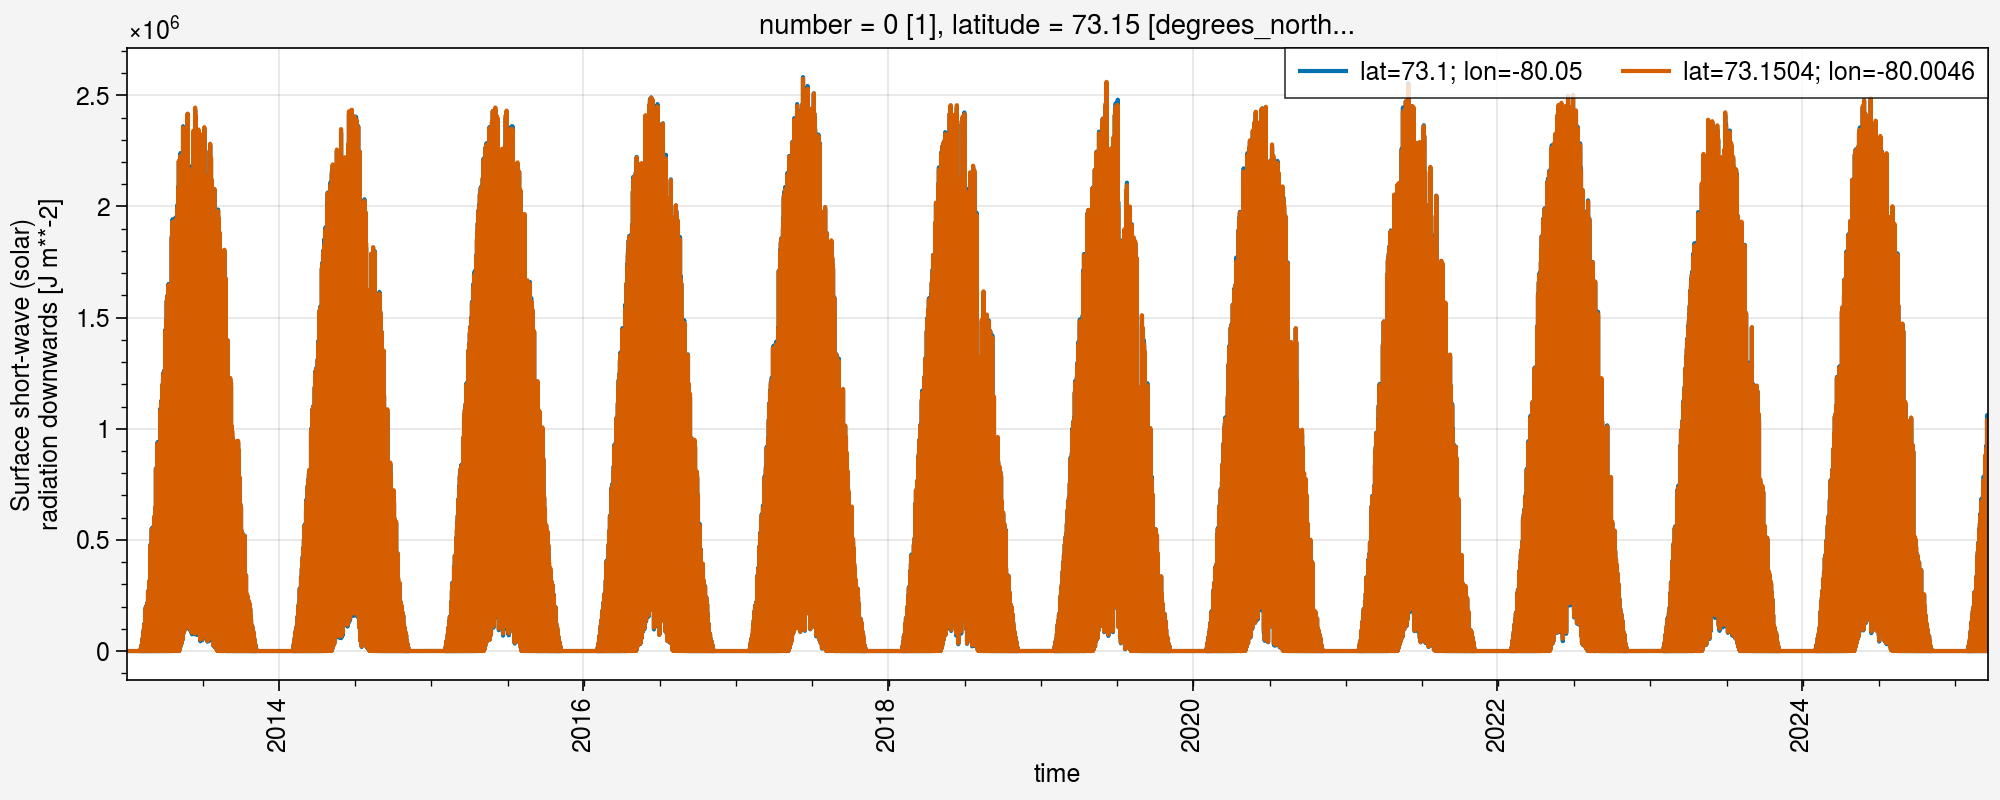

In [54]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.ssrd.sel(latitude=73.1, longitude=-80.05).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.ssrd.sel(latitude=73.1504, longitude=-80.0046).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

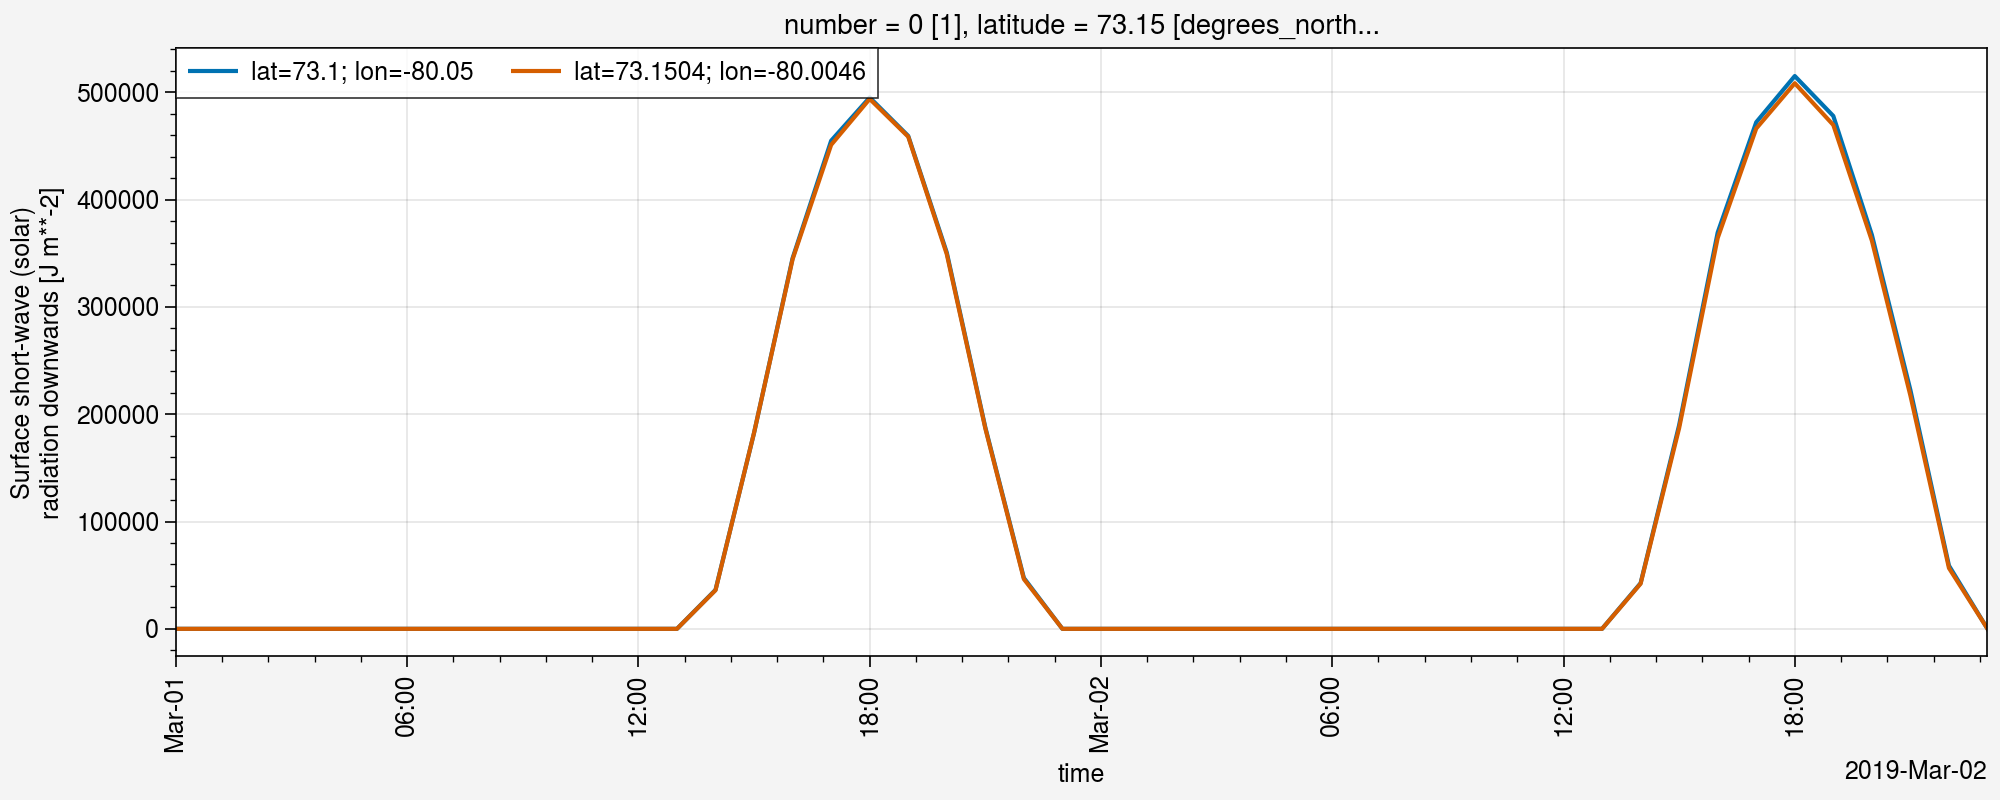

In [55]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.ssrd.sel(latitude=73.1, longitude=-80.05, valid_time=slice('2019-03-01', '2019-03-02')).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.ssrd.sel(latitude=73.1504, longitude=-80.0046, valid_time=slice('2019-03-01', '2019-03-02')).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

Need to divide by 3600 to get W m-2 s-1

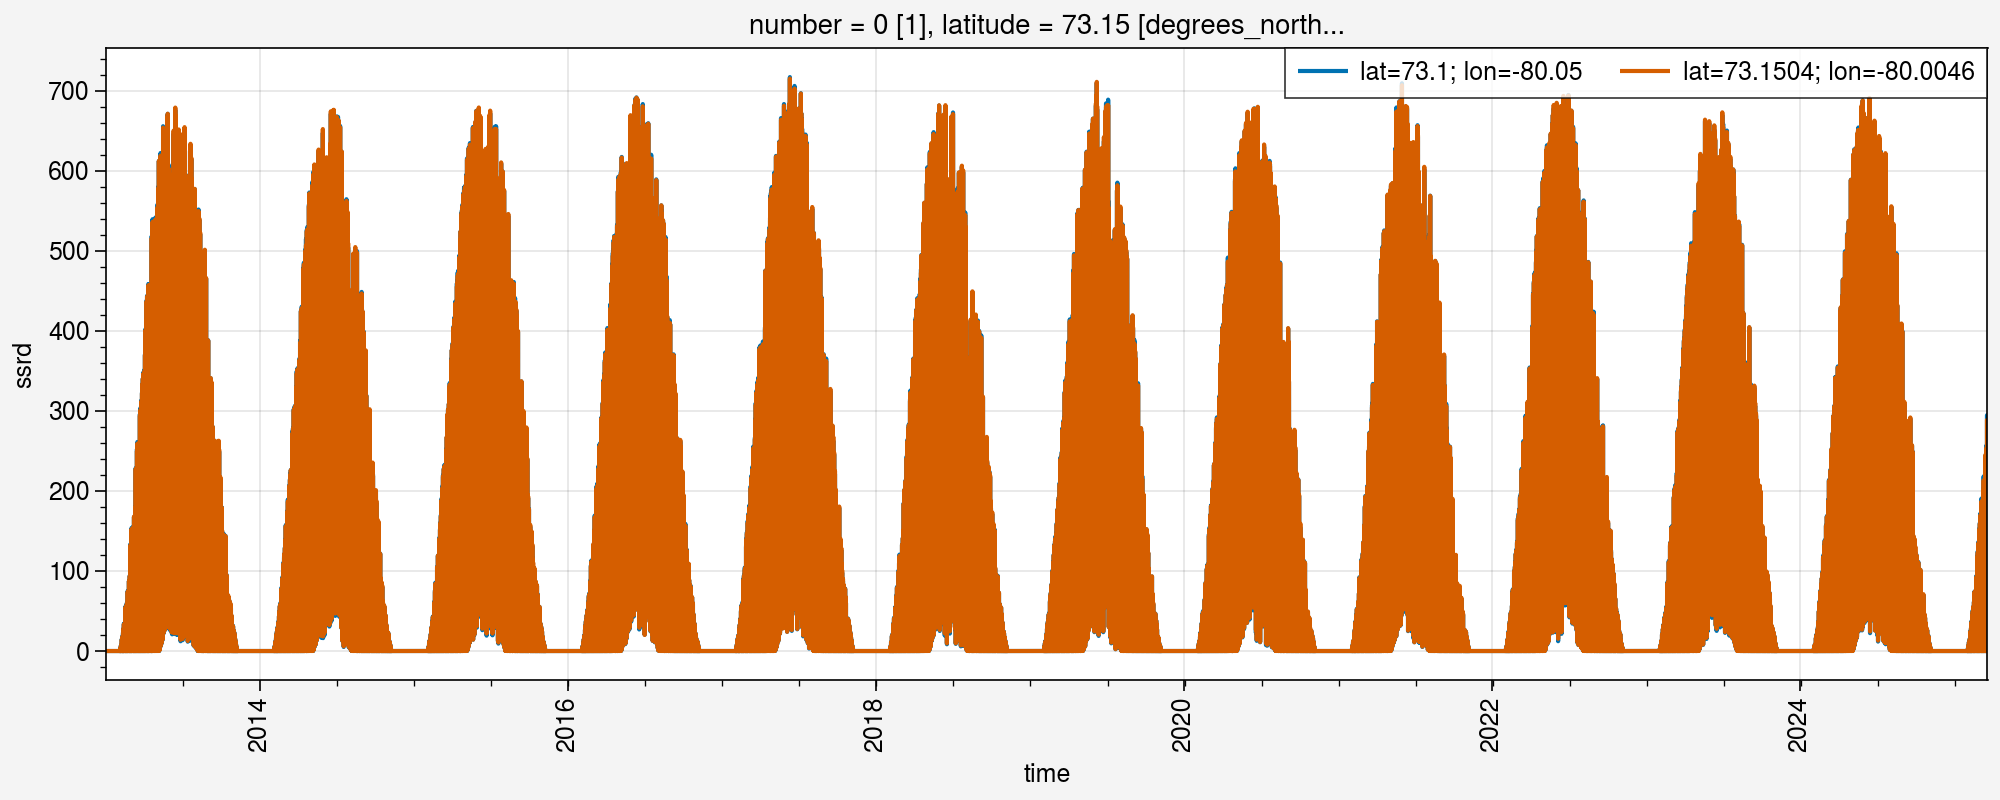

In [56]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

(ds_interp.ssrd.sel(latitude=73.1, longitude=-80.05)/3600).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
(ds_interp.ssrd.sel(latitude=73.1504, longitude=-80.0046)/3600).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

## Export data to .dat or .csv 
Only pixel including Bylot and interpolated values

In [57]:
ds_interp_out = ds_interp.ssrd.drop('number').drop('expver').rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds_interp_out = ds_interp_out/3600
ds_interp_out.attrs = {'long_name': 'Surface short-wave (solar) radiation downwards', 'name': 'ssrd', 'units': 'W m$^{-2}$ s$^{-1}$'}

ds_interp_out_grid = ds_interp_out.sel(lat=73.1, lon=-80.05)
ds_interp_out_interp = ds_interp_out.sel(lat=73.1504, lon=-80.0046)
ds_interp_out_interp

<xarray.DataArray 'ssrd' (time: 107110)> Size: 857kB
array([  0.        ,   0.        ,   0.        , ..., 259.57608686,
       232.3352197 , 174.27779114])
Coordinates:
  * time     (time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T21:00:00
    lat      float64 8B 73.15
    lon      float64 8B -80.0
Attributes:
    long_name:  Surface short-wave (solar) radiation downwards
    name:       ssrd
    units:      W m$^{-2}$ s$^{-1}$

In [58]:
df_grid = ds_interp_out_grid.to_dataframe()
df_grid

lat    lon        ssrd
time                                        
2013-01-01 00:00:00  73.1 -80.05    0.000000
2013-01-01 01:00:00  73.1 -80.05    0.000000
2013-01-01 02:00:00  73.1 -80.05    0.000000
2013-01-01 03:00:00  73.1 -80.05    0.000000
2013-01-01 04:00:00  73.1 -80.05    0.000000
...                   ...    ...         ...
2025-03-21 17:00:00  73.1 -80.05  238.899826
2025-03-21 18:00:00  73.1 -80.05  273.209115
2025-03-21 19:00:00  73.1 -80.05  262.037083
2025-03-21 20:00:00  73.1 -80.05  234.857431
2025-03-21 21:00:00  73.1 -80.05  176.719601

[107110 rows x 3 columns]

In [59]:
df_grid.to_csv(path+'/ERA5_h_ssrd_73.1N_80.05W_2013-2025_Bylot_UTC.csv')

In [60]:
df_interp = ds_interp_out_interp.to_dataframe()
df_interp

lat      lon        ssrd
time                                             
2013-01-01 00:00:00  73.1504 -80.0046    0.000000
2013-01-01 01:00:00  73.1504 -80.0046    0.000000
2013-01-01 02:00:00  73.1504 -80.0046    0.000000
2013-01-01 03:00:00  73.1504 -80.0046    0.000000
2013-01-01 04:00:00  73.1504 -80.0046    0.000000
...                      ...      ...         ...
2025-03-21 17:00:00  73.1504 -80.0046  234.778671
2025-03-21 18:00:00  73.1504 -80.0046  270.313973
2025-03-21 19:00:00  73.1504 -80.0046  259.576087
2025-03-21 20:00:00  73.1504 -80.0046  232.335220
2025-03-21 21:00:00  73.1504 -80.0046  174.277791

[107110 rows x 3 columns]

In [61]:
df_interp.to_csv(path+'/ERA5_h_ssrd_73.1504N_80.0046W_2013-2025_Bylot_interp_UTC.csv')

## Surface pressure

In [231]:
ds = xr.open_mfdataset(path+'/Surface_pressure/*.nc')
ds.load()

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 54548, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 436kB 2019-01-01 ... 2025-03-22T1...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 873kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    sp          (valid_time, latitude, longitude) float32 873kB 9.44e+04 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T21:54 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [232]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 2)> Size: 16B
array([73.35, 73.1 ])
Coordinates:
    number    int64 8B 0
  * latitude  (latitude) float64 16B 73.35 73.1
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [233]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds.latitude.values, lat))
new_lons = np.sort(np.append(ds.longitude.values, lon))

In [234]:
new_lats

array([73.1   , 73.1504, 73.35  ])

In [235]:
new_lons

array([-80.05  , -80.0046, -79.8   ])

In [236]:
ds_interp = ds.interp(latitude=new_lats, longitude=new_lons)
ds_interp

<xarray.Dataset> Size: 5MB
Dimensions:     (valid_time: 54548, latitude: 3, longitude: 3)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 436kB 2019-01-01 ... 2025-03-22T1...
    expver      (valid_time) <U4 873kB '0001' '0001' '0001' ... '0005' '0005'
  * latitude    (latitude) float64 24B 73.1 73.15 73.35
  * longitude   (longitude) float64 24B -80.05 -80.0 -79.8
Data variables:
    sp          (valid_time, latitude, longitude) float64 4MB 9.776e+04 ... 9...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T21:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [237]:
import warnings
warnings.filterwarnings('ignore')

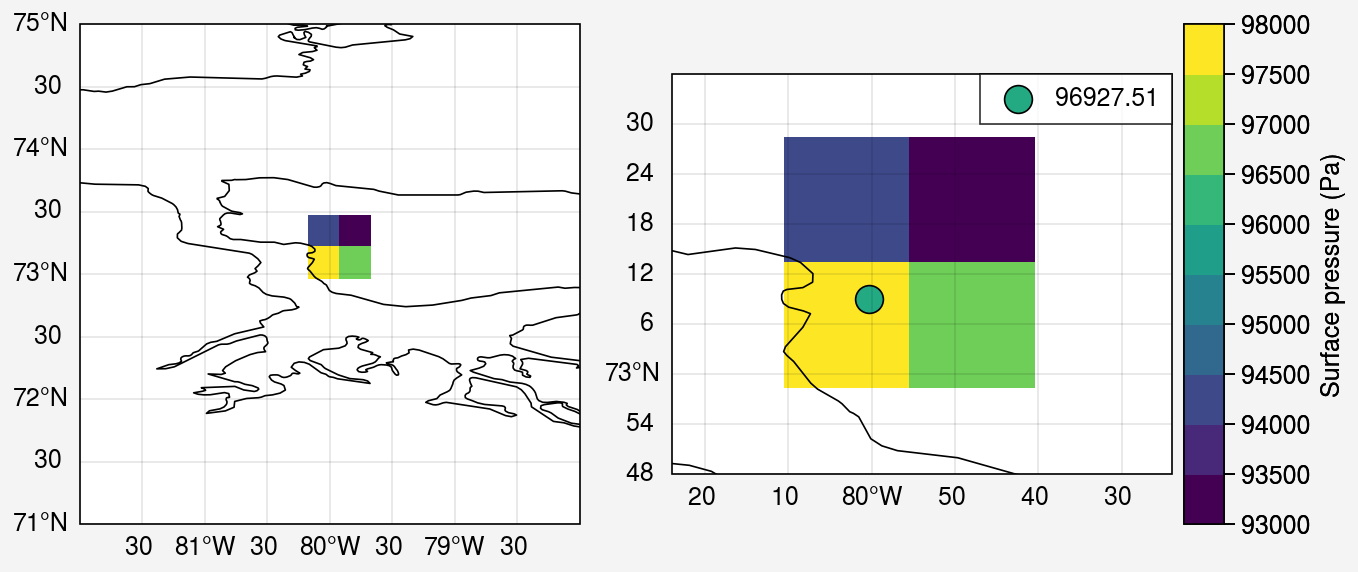

In [238]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 1000
ax = axs[0]
ax.pcolormesh(ds.sp[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds.sp[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.sp.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


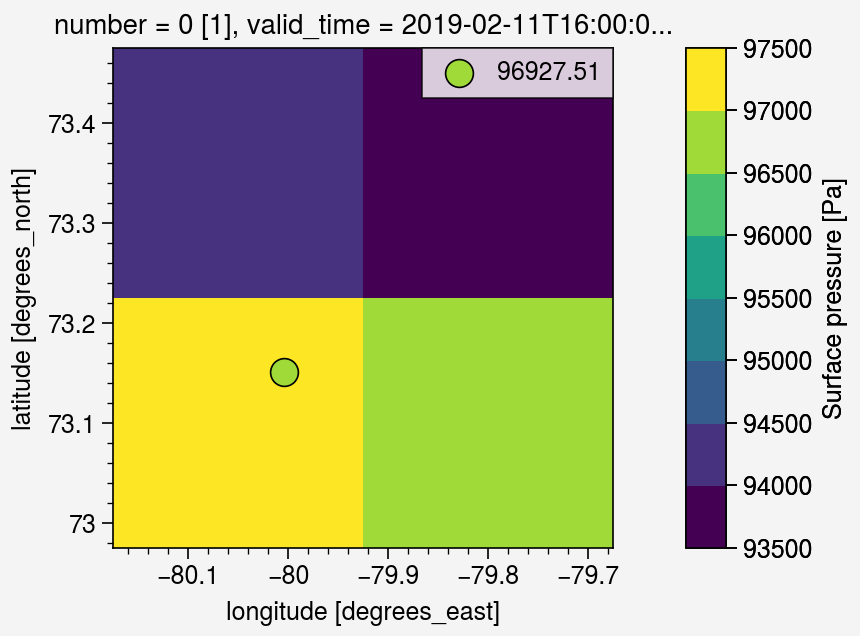

In [239]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 1000
pcolor = ds.sp[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.sp.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

In [240]:
ds_interp.latitude.values

array([73.1   , 73.1504, 73.35  ])

In [241]:
ds_interp.longitude.values

array([-80.05  , -80.0046, -79.8   ])

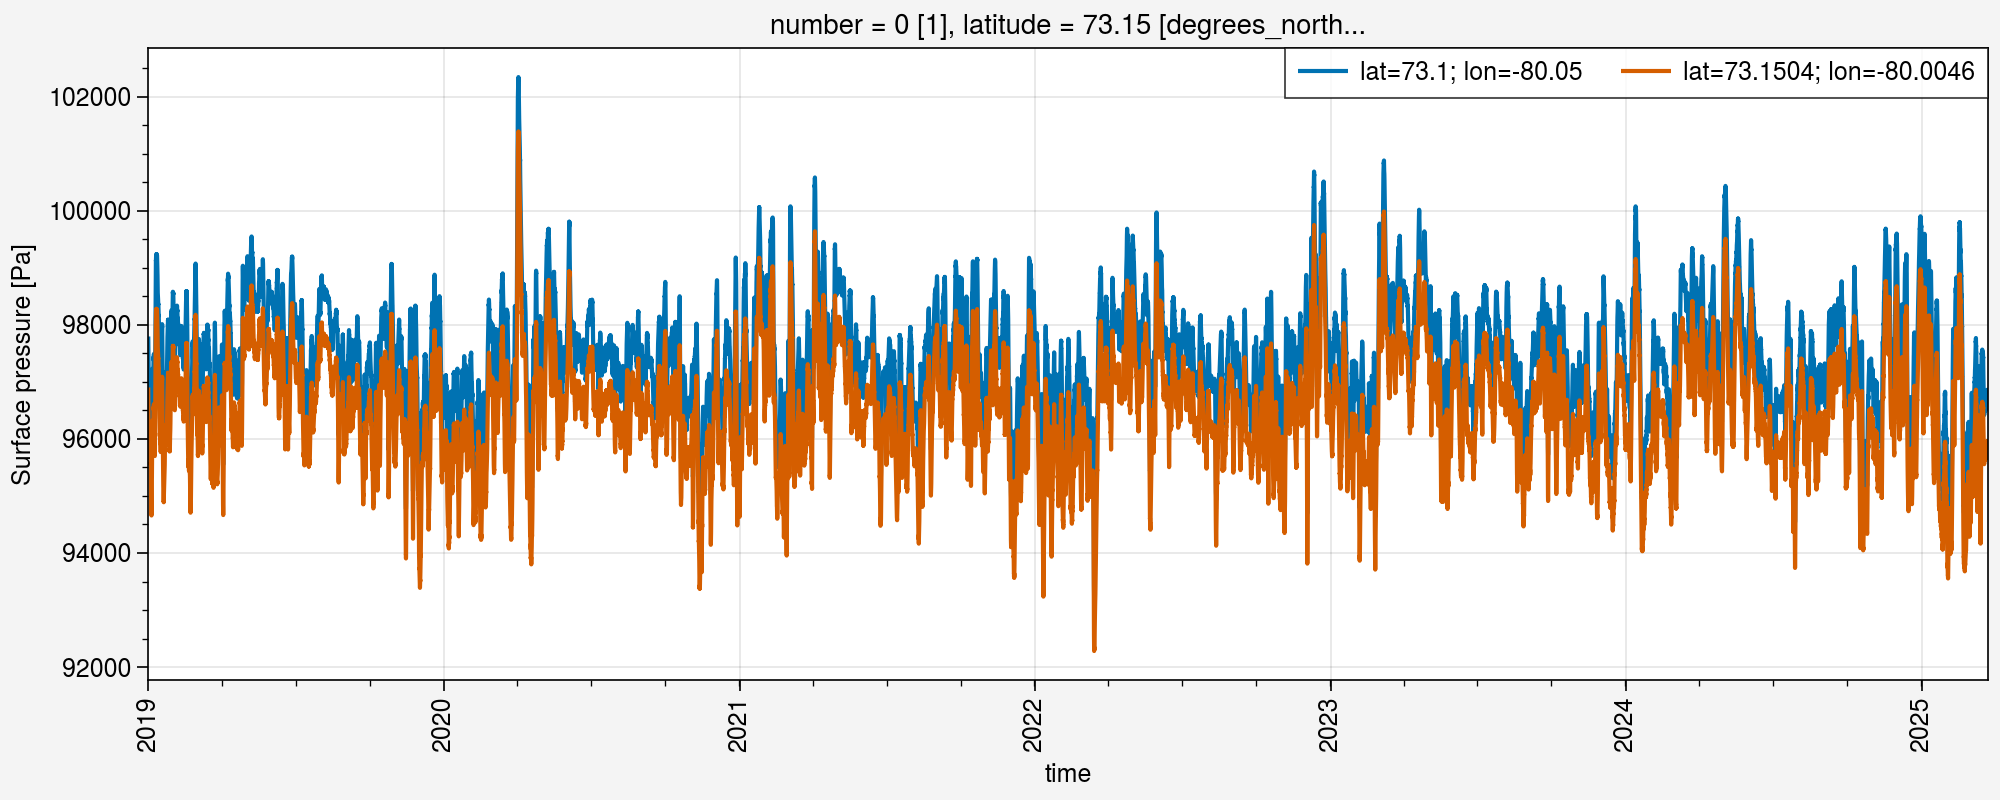

In [242]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.sp.sel(latitude=73.1, longitude=-80.05).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.sp.sel(latitude=73.1504, longitude=-80.0046).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

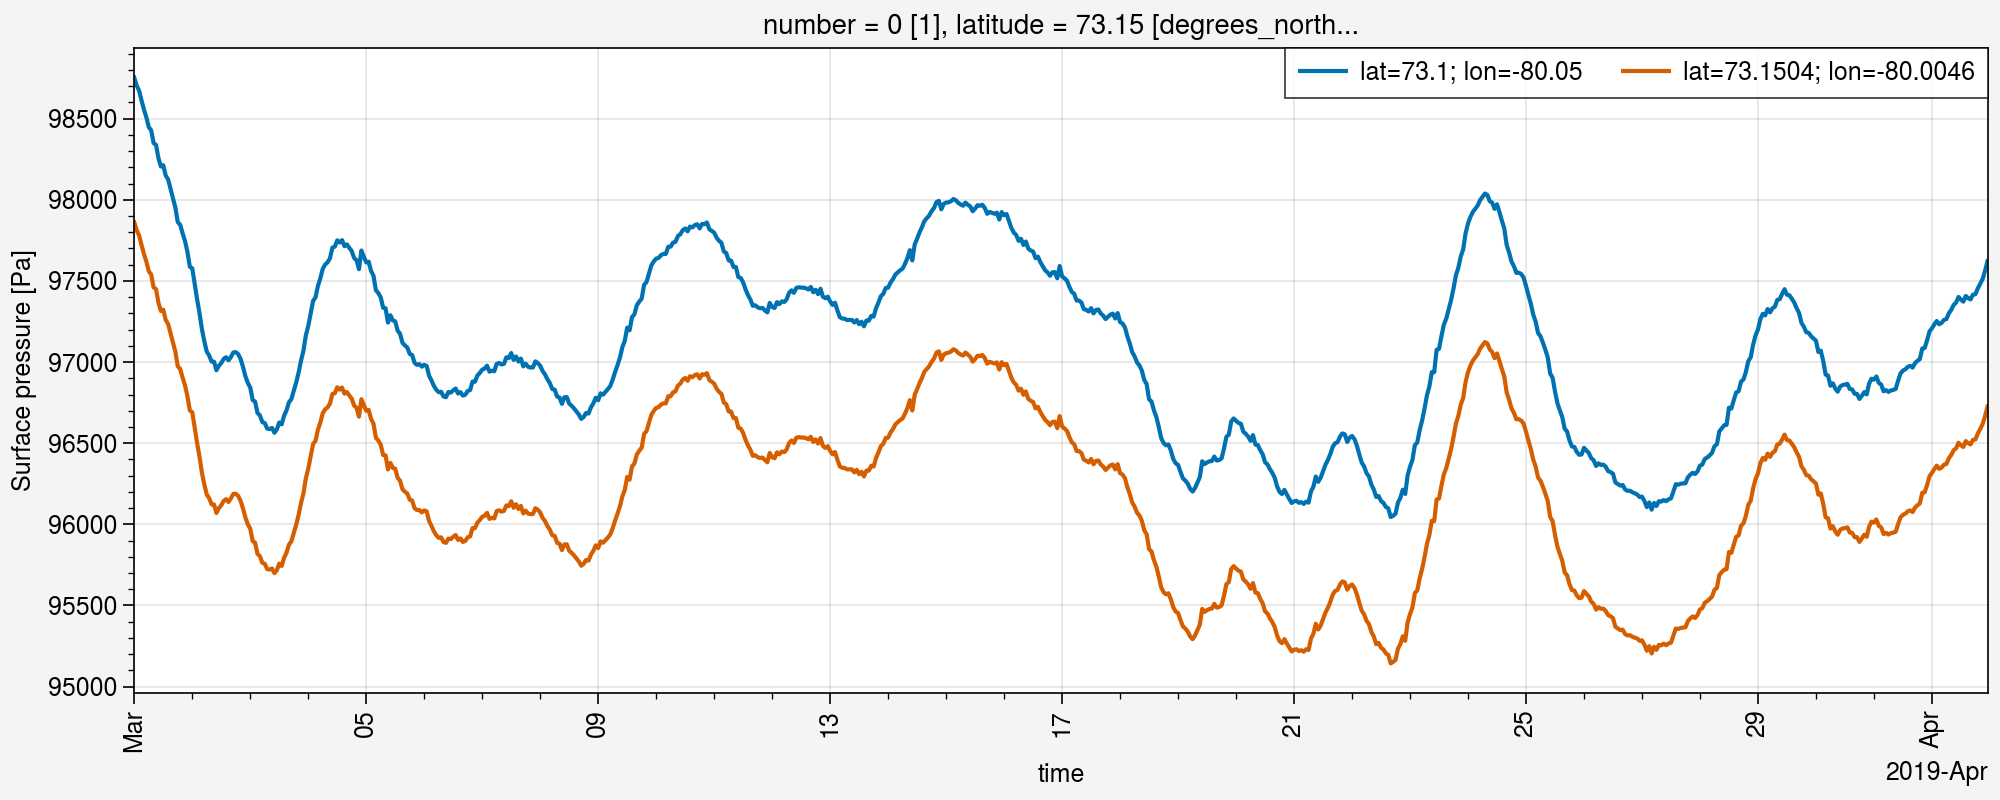

In [246]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.sp.sel(latitude=73.1, longitude=-80.05, valid_time=slice('2019-03-01', '2019-04-01')).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.sp.sel(latitude=73.1504, longitude=-80.0046, valid_time=slice('2019-03-01', '2019-04-01')).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

## Export data to .dat or .csv 
Only pixel including Bylot and interpolated values

In [249]:
ds_interp_out = ds_interp.sp.drop('number').drop('expver').rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds_interp_out.attrs = {'long_name': 'Surface pressure', 'name': 'sp', 'units': 'Pa'}

ds_interp_out_grid = ds_interp_out.sel(lat=73.1, lon=-80.05)
ds_interp_out_interp = ds_interp_out.sel(lat=73.1504, lon=-80.0046)
ds_interp_out_interp

<xarray.DataArray 'sp' (time: 54548)> Size: 436kB
array([96865.42324848, 96803.74246688, 96805.34745376, ...,
       95936.60905632, 95965.50722736, 95954.25062208])
Coordinates:
  * time     (time) datetime64[ns] 436kB 2019-01-01 ... 2025-03-22T19:00:00
    lat      float64 8B 73.15
    lon      float64 8B -80.0
Attributes:
    long_name:  Surface pressure
    name:       sp
    units:      Pa

In [250]:
df_grid = ds_interp_out_grid.to_dataframe()
df_grid

lat    lon          sp
time                                        
2019-01-01 00:00:00  73.1 -80.05  97759.1250
2019-01-01 01:00:00  73.1 -80.05  97698.1875
2019-01-01 02:00:00  73.1 -80.05  97701.1875
2019-01-01 03:00:00  73.1 -80.05  97667.6875
2019-01-01 04:00:00  73.1 -80.05  97658.2500
...                   ...    ...         ...
2025-03-22 15:00:00  73.1 -80.05  96836.6250
2025-03-22 16:00:00  73.1 -80.05  96851.1250
2025-03-22 17:00:00  73.1 -80.05  96833.8125
2025-03-22 18:00:00  73.1 -80.05  96862.8125
2025-03-22 19:00:00  73.1 -80.05  96851.6875

[54548 rows x 3 columns]

In [251]:
df_grid.to_csv(path+'/ERA5_h_sp_73.1N_80.05W_2019-2025_Bylot_UTC.csv')

In [252]:
df_interp = ds_interp_out_interp.to_dataframe()
df_interp

lat      lon            sp
time                                               
2019-01-01 00:00:00  73.1504 -80.0046  96865.423248
2019-01-01 01:00:00  73.1504 -80.0046  96803.742467
2019-01-01 02:00:00  73.1504 -80.0046  96805.347454
2019-01-01 03:00:00  73.1504 -80.0046  96771.585272
2019-01-01 04:00:00  73.1504 -80.0046  96763.042393
...                      ...      ...           ...
2025-03-22 15:00:00  73.1504 -80.0046  95939.409643
2025-03-22 16:00:00  73.1504 -80.0046  95953.398385
2025-03-22 17:00:00  73.1504 -80.0046  95936.609056
2025-03-22 18:00:00  73.1504 -80.0046  95965.507227
2025-03-22 19:00:00  73.1504 -80.0046  95954.250622

[54548 rows x 3 columns]

In [253]:
df_interp.to_csv(path+'/ERA5_h_sp_73.1504N_80.0046W_2019-2025_Bylot_interp_UTC.csv')

## Mean sea level pressure

In [5]:
ds = xr.open_mfdataset(path+'/Mean_sea_level_pressure/*.nc')
ds.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 102807, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 822kB 2013-07-01 ... 2025-03-23T1...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    msl         (valid_time, latitude, longitude) float32 2MB 1.006e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-01T14:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [273]:
ds = xr.open_mfdataset(path+'/Mean_sea_level_pressure/*.nc')
ds.load()

<xarray.Dataset> Size: 3MB
Dimensions:     (valid_time: 63327, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 507kB 2018-01-01 ... 2025-03-23T1...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 1MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    msl         (valid_time, latitude, longitude) float32 1MB 1.012e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-28T14:40 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [6]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 2)> Size: 16B
array([73.35, 73.1 ])
Coordinates:
    number    int64 8B 0
  * latitude  (latitude) float64 16B 73.35 73.1
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [7]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds.latitude.values, lat))
new_lons = np.sort(np.append(ds.longitude.values, lon))

In [8]:
new_lats

array([73.1   , 73.1504, 73.35  ])

In [9]:
new_lons

array([-80.05  , -80.0046, -79.8   ])

In [10]:
ds_interp = ds.interp(latitude=new_lats, longitude=new_lons)
ds_interp

<xarray.Dataset> Size: 10MB
Dimensions:     (valid_time: 102807, latitude: 3, longitude: 3)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 822kB 2013-07-01 ... 2025-03-23T1...
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
  * latitude    (latitude) float64 24B 73.1 73.15 73.35
  * longitude   (longitude) float64 24B -80.05 -80.0 -79.8
Data variables:
    msl         (valid_time, latitude, longitude) float64 7MB 1.007e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-01T14:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
import warnings
warnings.filterwarnings('ignore')

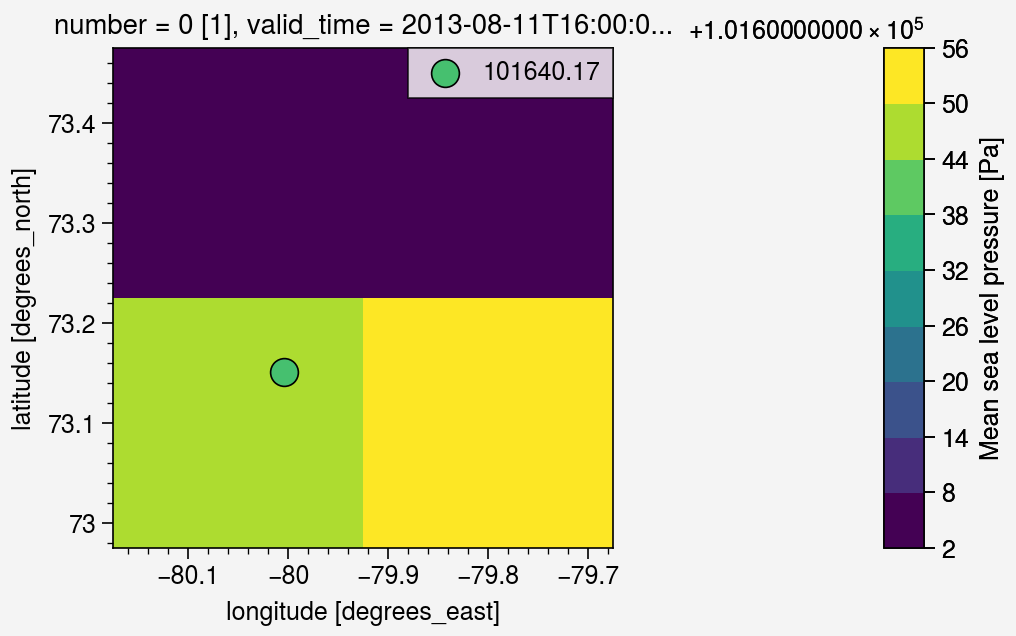

In [13]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 1000
pcolor = ds.msl[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.msl.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

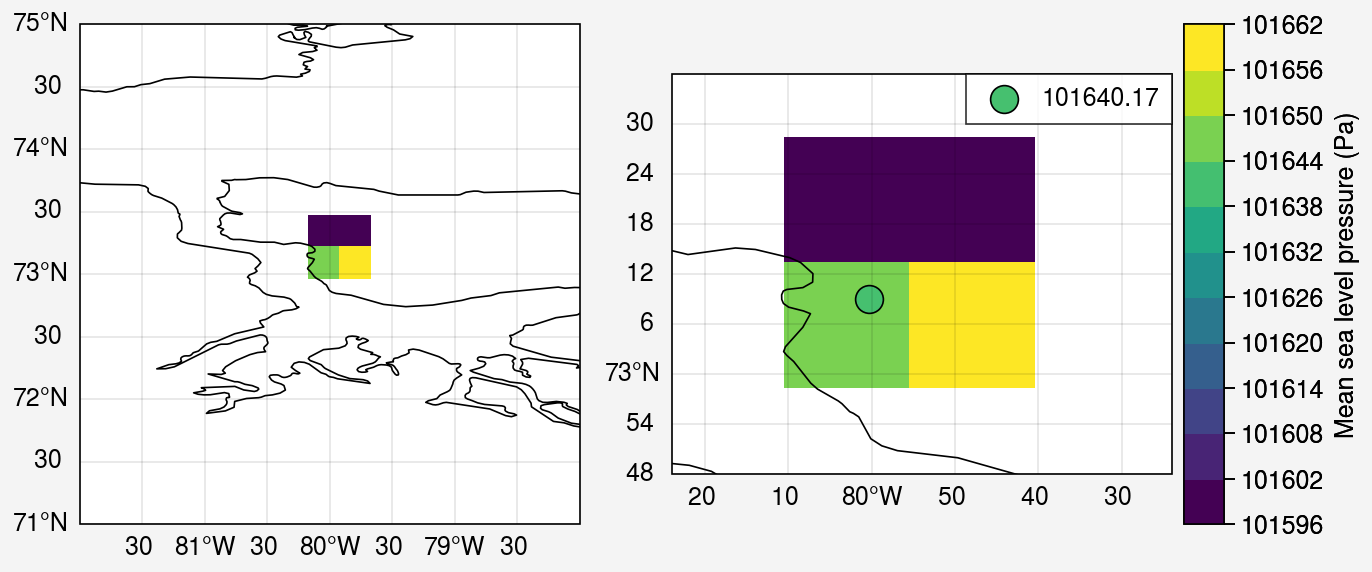

In [14]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 1000
ax = axs[0]
ax.pcolormesh(ds.msl[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds.msl[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.msl.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


In [15]:
ds_interp.latitude.values

array([73.1   , 73.1504, 73.35  ])

In [16]:
ds_interp.longitude.values

array([-80.05  , -80.0046, -79.8   ])

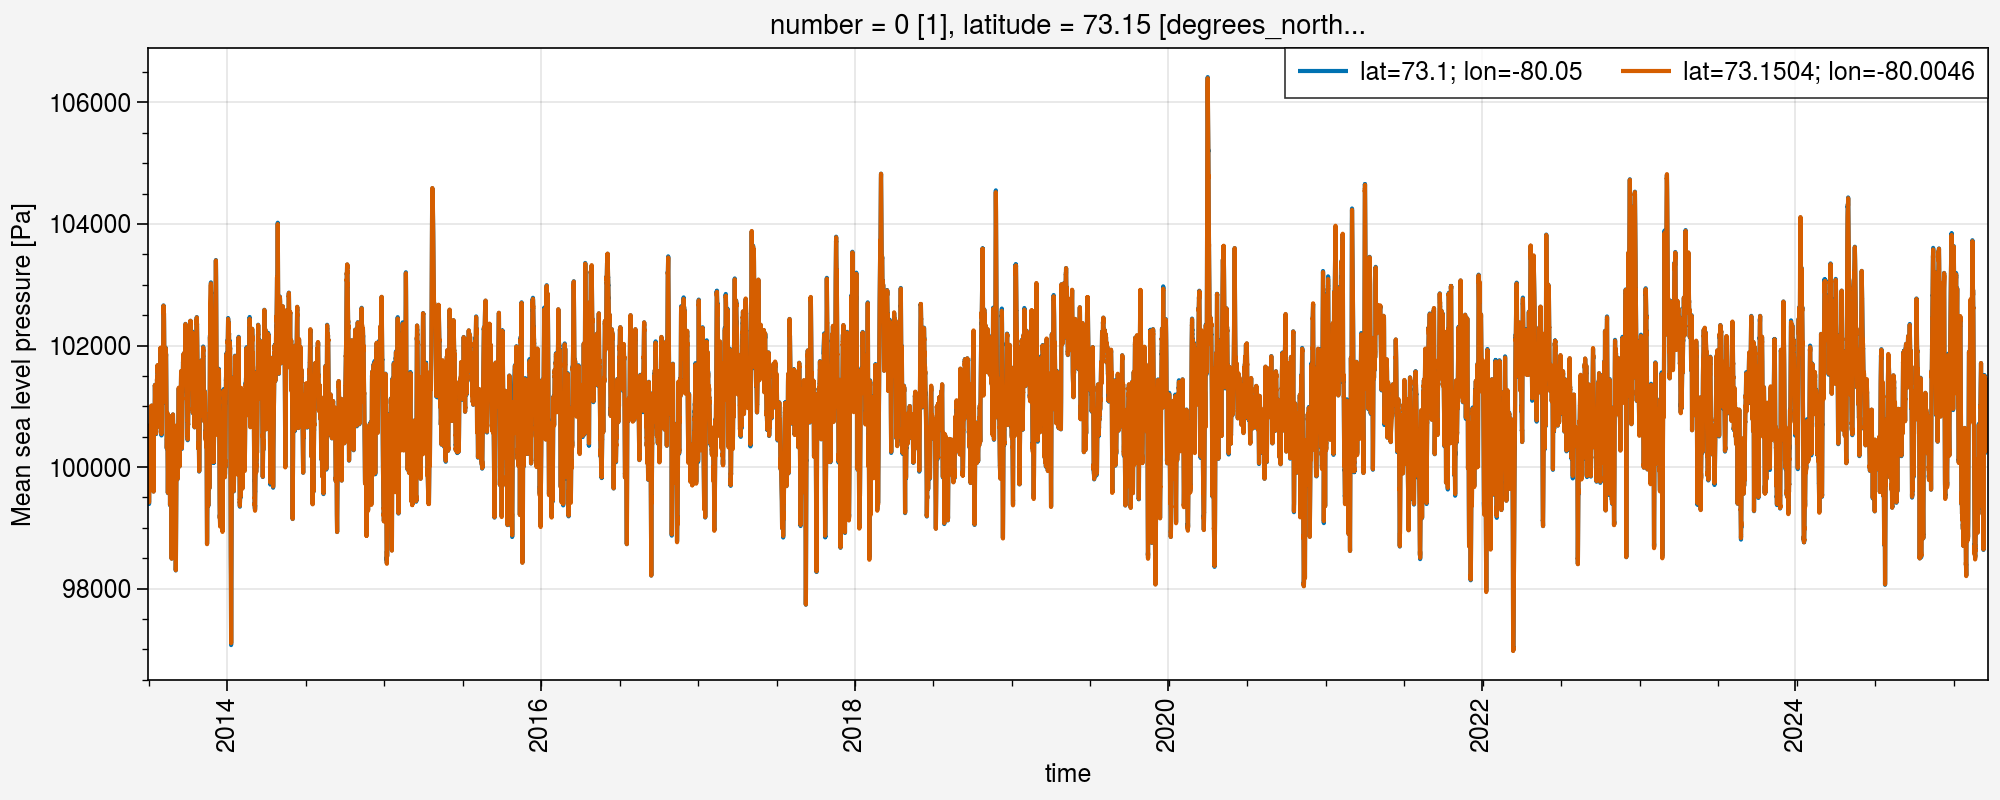

In [17]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.msl.sel(latitude=73.1, longitude=-80.05).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.msl.sel(latitude=73.1504, longitude=-80.0046).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

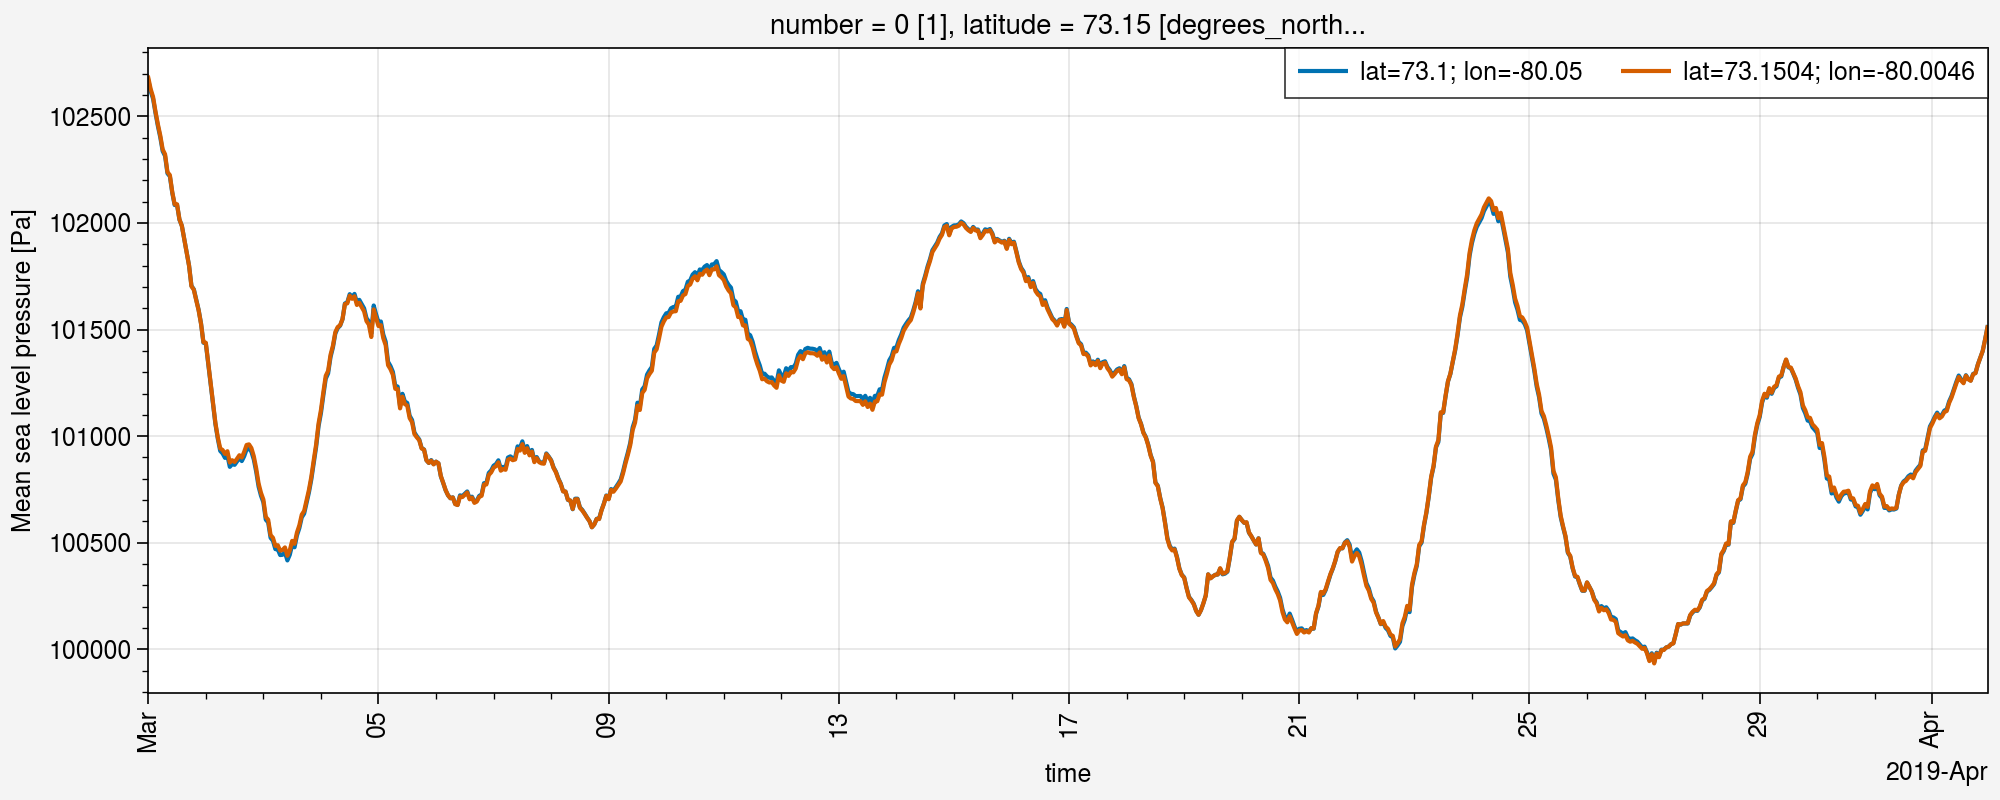

In [18]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.msl.sel(latitude=73.1, longitude=-80.05, valid_time=slice('2019-03-01', '2019-04-01')).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.msl.sel(latitude=73.1504, longitude=-80.0046, valid_time=slice('2019-03-01', '2019-04-01')).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

## Export data to .dat or .csv 
Only pixel including Bylot and interpolated values

In [19]:
ds_interp_out = ds_interp.msl.drop('number').drop('expver').rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds_interp_out.attrs = {'long_name': 'Mean sea level pressure', 'name': 'msl', 'units': 'Pa'}

ds_interp_out_grid = ds_interp_out.sel(lat=73.1, lon=-80.05)
ds_interp_out_interp = ds_interp_out.sel(lat=73.1504, lon=-80.0046)
ds_interp_out_interp

<xarray.DataArray 'msl' (time: 102807)> Size: 822kB
array([100662.14192026, 100630.56397553, 100561.09007923, ...,
       101367.58406213, 101424.60633762, 101412.01466626])
Coordinates:
  * time     (time) datetime64[ns] 822kB 2013-07-01 ... 2025-03-23T14:00:00
    lat      float64 8B 73.15
    lon      float64 8B -80.0
Attributes:
    long_name:  Mean sea level pressure
    name:       msl
    units:      Pa

In [21]:
df_grid = ds_interp_out_grid.to_dataframe()
df_grid

lat    lon            msl
time                                           
2013-07-01 00:00:00  73.1 -80.05  100666.820312
2013-07-01 01:00:00  73.1 -80.05  100635.570312
2013-07-01 02:00:00  73.1 -80.05  100565.257812
2013-07-01 03:00:00  73.1 -80.05  100494.359375
2013-07-01 04:00:00  73.1 -80.05  100470.750000
...                   ...    ...            ...
2025-03-23 10:00:00  73.1 -80.05  101304.578125
2025-03-23 11:00:00  73.1 -80.05  101356.171875
2025-03-23 12:00:00  73.1 -80.05  101381.453125
2025-03-23 13:00:00  73.1 -80.05  101438.828125
2025-03-23 14:00:00  73.1 -80.05  101426.242188

[102807 rows x 3 columns]

In [22]:
df_grid.to_csv(path+'/ERA5_h_msl_73.1N_80.05W_2013-2025_Bylot_UTC.csv')

In [23]:
df_interp = ds_interp_out_interp.to_dataframe()
df_interp

lat      lon            msl
time                                                
2013-07-01 00:00:00  73.1504 -80.0046  100662.141920
2013-07-01 01:00:00  73.1504 -80.0046  100630.563976
2013-07-01 02:00:00  73.1504 -80.0046  100561.090079
2013-07-01 03:00:00  73.1504 -80.0046  100490.842747
2013-07-01 04:00:00  73.1504 -80.0046  100467.868317
...                      ...      ...            ...
2025-03-23 10:00:00  73.1504 -80.0046  101291.408897
2025-03-23 11:00:00  73.1504 -80.0046  101342.708958
2025-03-23 12:00:00  73.1504 -80.0046  101367.584062
2025-03-23 13:00:00  73.1504 -80.0046  101424.606338
2025-03-23 14:00:00  73.1504 -80.0046  101412.014666

[102807 rows x 3 columns]

In [24]:
df_interp.to_csv(path+'/ERA5_h_msl_73.1504N_80.0046W_2013-2025_Bylot_interp_UTC.csv')